In [34]:
import pandas as pd
import numpy as np
import sys
import datetime
import matplotlib.pyplot as plt
from itertools import product

YEAR_A = 2009
YEAR_B = 2020

In [35]:
def read_csv(s):
    df = pd.read_csv(s)
    df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
    df.set_index('timestamp', inplace=True)
    df.drop(["101_DKA_WeatherStation_Wind_Direction",
             "101_DKA_WeatherStation_Wind_Speed",
             "101_DKA_WeatherStation_Weather_Relative_Humidity",
             "101_DKA_WeatherStation_Radiation_Global_Tilted",
             "101_DKA_WeatherStation_Radiation_Diffuse_Tilted",
             ], axis=1, inplace=True)
    return df


def open_datasets(*args):
    return (read_csv(arg) for arg in args)


df_a, df_b = open_datasets(f"Alice_Springs_{YEAR_A}.zip", f"Alice_Springs_{YEAR_B}.zip")

In [51]:
class DayPair:
    """Pair of day dataframe groups"""
    COLS = ["101_DKA_WeatherStation_Global_Horizontal_Radiation",
            "101_DKA_WeatherStation_Weather_Temperature_Celsius"]

    def __init__(self, a, b):
        self.a = a
        self.b = b
        self.similarity = np.prod([self.cosine_similarity(a[1][col], b[1][col]) for col in self.COLS])

    def plot(self, cols=None, title=None, ylabel="kW", save=None):
        cols = cols if cols is not None else self.COLS
        title = title if title is not None else f"PV Degradation Rate: {self.a[0][0]} vs. {self.b[0][0]}"
        out = pd.concat((self.a[1][cols], self.b[1][cols]), axis=1)
        out.columns = [f"{year}_{col}" for year in (self.a[0][0], self.b[0][0]) for col in cols]
        out.set_index(out.index.hour * 60 + out.index.minute, inplace=True)
        out.index.name = "Minute"
        styles = [f"{l}C{i}" for l in ('-', '--') for i in range(len(cols))]
        ax = out.plot(style=styles, legend=False, title=title)
        ax.set_ylabel(ylabel=ylabel)
        return ax

    @staticmethod
    def cosine_similarity(x, y):
        return np.dot(x, y) / np.linalg.norm(x) / np.linalg.norm(y)

In [52]:
def group_days(df):
    return [group for group in df.groupby([df.index.year, df.index.month, df.index.day]) if len(group[1]) == 12 * 24]


cols = [col for col in df_a.columns.values if 'Active_Power' in col or '101_DKA' in col]
days_a, days_b = group_days(df_a[cols]), group_days(df_b[cols])
pairs = list(
    sorted((DayPair(a, b) for a, b in product(days_a, days_b)), key=lambda pair: pair.similarity, reverse=True))

(2009, 1, 2) (2020, 1, 17)


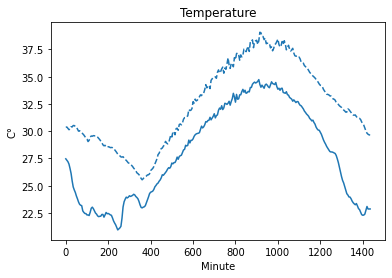

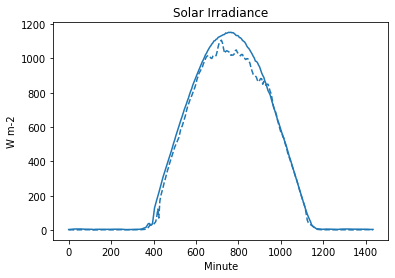

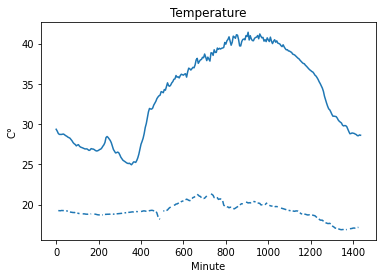

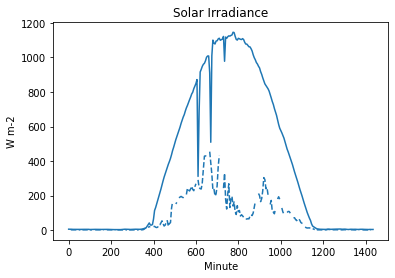

In [59]:
print(pairs[0].a[0], pairs[0].b[0])
pairs[0].plot(cols=DayPair.COLS[1:], title="Temperature", ylabel="C°")
plt.savefig("temp_similar.png")
pairs[0].plot(cols=DayPair.COLS[:1], title="Solar Irradiance", ylabel="W m-2")
plt.savefig("kw_similar.png")
pairs[-10].plot(cols=DayPair.COLS[1:], title="Temperature", ylabel="C°")
plt.savefig("temp_different.png")
pairs[-10].plot(cols=DayPair.COLS[:1], title="Solar Irradiance", ylabel="W m-2")
plt.savefig("kw_different.png")

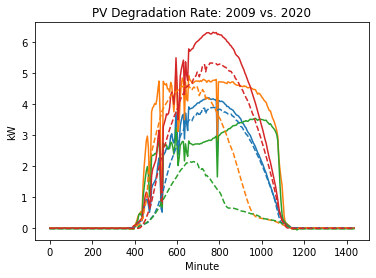

In [39]:
def plot_decay():
    pair = pairs[0]
    df = pair.a[1]
    df.fillna(0, inplace=True)
    cols = df.drop(columns=df.columns[(df.mean() < 1)], axis=1).columns.values[:4]
    pair.plot(cols=cols)
    plt.savefig("decay.png")

plot_decay()

<AxesSubplot:title={'center':'PV Degradation Rate: 2009 vs. 2020'}, xlabel='Minute', ylabel='kW'>

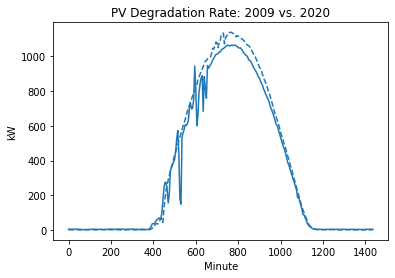

In [40]:
pairs[0].plot(cols=DayPair.COLS[:1])

In [41]:
pair = pairs[0]
a = pair.a[1].reset_index()
b = pair.b[1].reset_index()
diff = (a - b).drop(["timestamp",
                     "101_DKA_WeatherStation_Global_Horizontal_Radiation",
                     "95_6_Kyocera_Active_Power",
                     "96_DKA_MasterMeter1_Active_Power",
                     ], axis=1)
maximums = diff.idxmax(axis=1)
maximums.mode()[0]

'85_10_SunPower_Active_Power'